##Connect to drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!pwd
# Change directory
%cd ../content/gdrive/MyDrive/Colab Notebooks/Kaggle/NLP0
!pwd

/content
/content/gdrive/MyDrive/Colab Notebooks/Kaggle/NLP0
/content/gdrive/MyDrive/Colab Notebooks/Kaggle/NLP0


# Setup

Libraries

In [57]:
import pandas as pd
import zipfile
# NLTK
import nltk
nltk.download('punkt')
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
# Plots
import matplotlib.pyplot as plt
from wordcloud import WordCloud
nltk.download('averaged_perceptron_tagger')
from matplotlib.gridspec import GridSpec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [5]:
# Create data folder
#%mkdir data

#Data preparation

## Extract data

In [6]:
# Extract from xip file
# with zipfile.ZipFile("nlp-getting-started.zip", 'r') as zip_ref:
#     zip_ref.extractall("data")

In [7]:
# read in training data
data = pd.read_csv("data/train.csv")
data.reset_index(inplace=True)

In [8]:
# data info
print("Shape:",data.shape)
print("Columns:\n",data.columns)
print(data.head(5))
print("Missing volumes:\n",data.isna().sum())

Shape: (7613, 6)
Columns:
 Index(['index', 'id', 'keyword', 'location', 'text', 'target'], dtype='object')
   index  id keyword location  \
0      0   1     NaN      NaN   
1      1   4     NaN      NaN   
2      2   5     NaN      NaN   
3      3   6     NaN      NaN   
4      4   7     NaN      NaN   

                                                text  target  
0  Our Deeds are the Reason of this #earthquake M...       1  
1             Forest fire near La Ronge Sask. Canada       1  
2  All residents asked to 'shelter in place' are ...       1  
3  13,000 people receive #wildfires evacuation or...       1  
4  Just got sent this photo from Ruby #Alaska as ...       1  
Missing volumes:
 index          0
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


## Create helper ds

In [9]:
# Sentences into list
sent_all = []
sent_idx = []
for s in range(len(data)):
  sent_all += sent_tokenize(data.text[s])
  sent_idx += [s]*len(sent_tokenize(data.text[s]))
print(sent_all[:3])
print(sent_idx[:3])

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all', 'Forest fire near La Ronge Sask.', 'Canada']
[0, 1, 1]


In [10]:
# Combine into dataframe
sent = pd.DataFrame()
sent['idx'] = sent_idx
sent['sent'] = sent_all
sent

,idx,sent
0,0,Our Deeds are the Reason of this #earthquake M...
1,1,Forest fire near La Ronge Sask.
2,1,Canada
3,2,All residents asked to 'shelter in place' are ...
4,2,No other evacuation or shelter in place orders...
...,...,...
11549,7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii.
11550,7610,http://t.co/zDtoyd8EbJ
11551,7611,Police investigating after an e-bike collided ...
11552,7611,E-bike rider suffered serious non-life threate...


In [52]:
# Combine all words
words_all = []
words_idx = []
words_tgt = []
for s in range(len(data)):
  words_all += word_tokenize(data.text[s])
  words_idx += [s]*len(word_tokenize(data.text[s]))
  words_tgt += [data.target[s]]*len(word_tokenize(data.text[s]))
print(words_all[:3])
print(words_idx[:3])
print(words_tgt[:3])

['Our', 'Deeds', 'are']
[0, 0, 0]
[1, 1, 1]


In [53]:
# Combine into dataframe
words = pd.DataFrame()
words['idx'] = words_idx
words['tgt'] = words_tgt
words['word'] = words_all
words

,idx,tgt,word
0,0,1,Our
1,0,1,Deeds
2,0,1,are
3,0,1,the
4,0,1,Reason
...,...,...,...
143737,7612,1,ABC
143738,7612,1,News
143739,7612,1,http
143740,7612,1,:


In [54]:
# Remove punctuation
words_pnk = []
for w in range(len(words)):
  if words.word[w].isalpha():
    words_pnk.append(words.loc[w])
words_pnk = pd.DataFrame(words_pnk, columns = words.columns)
words_pnk.reset_index(inplace=True, drop=True)
words_pnk[4:]

,idx,tgt,word
4,0,1,Reason
5,0,1,of
6,0,1,this
7,0,1,earthquake
8,0,1,May
...,...,...,...
105699,7612,1,California
105700,7612,1,Wildfire
105701,7612,1,ABC
105702,7612,1,News


In [55]:
# Remove stopwords
stpwords = stopwords.words("english")
words_stp = []
for w in range(len(words_pnk)):
  if words_pnk.word[w] not in stpwords:
    words_stp.append(words_pnk.loc[w])
words_stp = pd.DataFrame(words_stp, columns = words.columns)
words_stp.reset_index(inplace=True, drop=True)
words_stp

,idx,tgt,word
0,0,1,Our
1,0,1,Deeds
2,0,1,Reason
3,0,1,earthquake
4,0,1,May
...,...,...,...
76258,7612,1,California
76259,7612,1,Wildfire
76260,7612,1,ABC
76261,7612,1,News


In [56]:
# Stemming
porter = PorterStemmer()
for w in range(len(words_stp)):
  words_stp.loc[w,'word_ste'] = porter.stem(words_stp.word.loc[w])
words_stp

,idx,tgt,word,word_ste
0,0,1,Our,our
1,0,1,Deeds,deed
2,0,1,Reason,reason
3,0,1,earthquake,earthquak
4,0,1,May,may
...,...,...,...,...
76258,7612,1,California,california
76259,7612,1,Wildfire,wildfir
76260,7612,1,ABC,abc
76261,7612,1,News,new


In [98]:
# Add tag
for w in range(len(words_stp)):
  words_stp.loc[w,'tag'] = nltk.pos_tag([words_stp.word[w]])[0][1].replace('$', '')
print(words_stp.head(5))
print(words_stp.groupby('tag').tag.count())

   idx  tgt        word   word_ste  tag
0    0    1         Our        our  PRP
1    0    1       Deeds       deed  NNS
2    0    1      Reason     reason   NN
3    0    1  earthquake  earthquak   NN
4    0    1         May        may  NNP
tag
CC        197
CD        371
DT       1500
EX         56
FW          1
IN       1981
JJ       3910
JJR        73
JJS       309
MD        511
NN      43381
NNP      2859
NNPS        8
NNS      8050
PRP      2285
RB       2308
RBR       129
SYM         4
TO        109
UH         34
VB       1808
VBD       734
VBG      2468
VBN      2644
VBZ       197
WDT        13
WP        120
WRB       203
Name: tag, dtype: int64


## Describe

(array([41951.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 34312.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

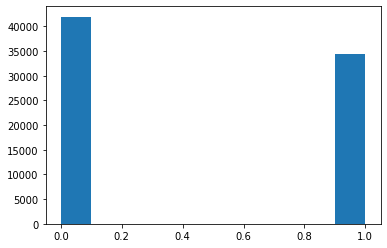

In [94]:
# Target var
plt.hist(words_stp.tgt)

[('http', 4716), ('I', 1546), ('the', 641), ('like', 408), ('fire', 355), ('amp', 344), ('new', 339), ('get', 309), ('A', 300), ('bomb', 230)]


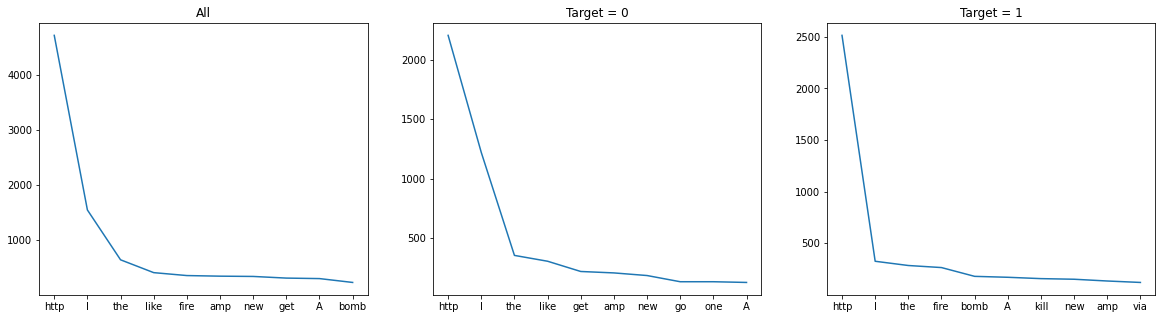

In [93]:
# Words frequencies
#fdist = FreqDist(words.word)
#fdist = FreqDist(words_pnk.word)
#fdist = FreqDist(words_stp.word)
fdist = FreqDist(words_stp.word_ste)
fdist0 = FreqDist(words_stp[words_stp.tgt==0].word_ste)
fdist1 = FreqDist(words_stp[words_stp.tgt==1].word_ste)
print(fdist.most_common(10))

fig = plt.figure(figsize=(20, 5))
gs = GridSpec(nrows=1, ncols=3)

ax0 = fig.add_subplot(gs[0, 0])
ax0.plot([fdist.most_common(10)[x][0] for x in range(10)],[fdist.most_common(10)[x][1] for x in range(10)])
ax0.title.set_text("All")

ax0 = fig.add_subplot(gs[0, 1])
ax0.plot([fdist0.most_common(10)[x][0] for x in range(10)],[fdist0.most_common(10)[x][1] for x in range(10)])
ax0.title.set_text("Target = 0")

ax0 = fig.add_subplot(gs[0, 2])
ax0.plot([fdist1.most_common(10)[x][0] for x in range(10)],[fdist1.most_common(10)[x][1] for x in range(10)])
ax0.title.set_text("Target = 1")

plt.show()

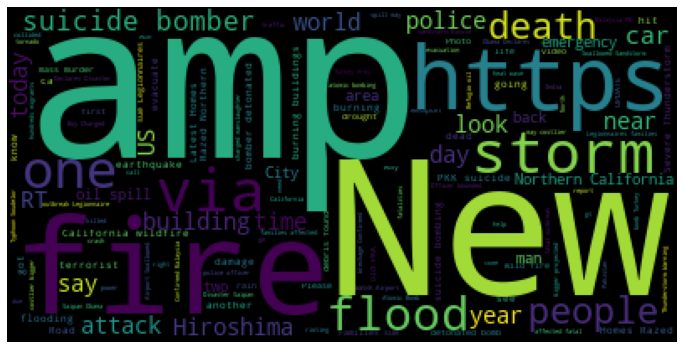

In [97]:
# Cloud of words
wordcloud = WordCloud().generate(" ".join(words_stp[words_stp.tgt==1].word))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()